In [ ]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already installed
pip install pyspark

fi

bash: line 6: syntax error near unexpected token `fi'
bash: line 6: `fi'


In [ ]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!wget https://raw.githubusercontent.com/zakhikhan/dataset/main/cal_housing.data

--2022-05-03 16:06:32--  https://raw.githubusercontent.com/zakhikhan/dataset/main/cal_housing.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2071484 (2.0M) [text/plain]
Saving to: ‘cal_housing.data.3’

cal_housing.data.3  100%[===================>]   1.97M  --.-KB/s    in 0.04s   

2022-05-03 16:06:32 (44.1 MB/s) - ‘cal_housing.data.3’ saved [2071484/2071484]



In [ ]:
spark = SparkSession.builder.master("local[*]").appName("IST 718 Final Project").getOrCreate()

In [ ]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Linear-Regression-California-Housing>

In [ ]:
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medianage", FloatType(), nullable=True),
    StructField("rooms", FloatType(), nullable=True),
    StructField("bedrooms", FloatType(), nullable=True),
    StructField("population", FloatType(), nullable=True),
    StructField("households", FloatType(), nullable=True),
    StructField("medianincome", FloatType(), nullable=True),
    StructField("medianhousevalue", FloatType(), nullable=True)]
)

In [ ]:
housing_california = '/content/cal_housing.data'

In [ ]:
df = spark.read.csv(path = housing_california, schema = schema)


In [ ]:
df.show(5)

+-------+-----+---------+------+--------+----------+----------+------------+----------------+
|   long|  lat|medianage| rooms|bedrooms|population|households|medianincome|medianhousevalue|
+-------+-----+---------+------+--------+----------+----------+------------+----------------+
|-122.23|37.88|     41.0| 880.0|   129.0|     322.0|     126.0|      8.3252|        452600.0|
|-122.22|37.86|     21.0|7099.0|  1106.0|    2401.0|    1138.0|      8.3014|        358500.0|
|-122.24|37.85|     52.0|1467.0|   190.0|     496.0|     177.0|      7.2574|        352100.0|
|-122.25|37.85|     52.0|1274.0|   235.0|     558.0|     219.0|      5.6431|        341300.0|
|-122.25|37.85|     52.0|1627.0|   280.0|     565.0|     259.0|      3.8462|        342200.0|
+-------+-----+---------+------+--------+----------+----------+------------+----------------+
only showing top 5 rows



In [ ]:
# show the dataframe columns
df.columns

['long',
 'lat',
 'medianage',
 'rooms',
 'bedrooms',
 'population',
 'households',
 'medianincome',
 'medianhousevalue']

In [ ]:
df.select('population','bedrooms').show(10)

+----------+--------+
|population|bedrooms|
+----------+--------+
|     322.0|   129.0|
|    2401.0|  1106.0|
|     496.0|   190.0|
|     558.0|   235.0|
|     565.0|   280.0|
|     413.0|   213.0|
|    1094.0|   489.0|
|    1157.0|   687.0|
|    1206.0|   665.0|
|    1551.0|   707.0|
+----------+--------+
only showing top 10 rows



In [ ]:
result_df = df.groupBy("medianage").count().sort("medianage", ascending=False)
result_df.show(10)


+---------+-----+
|medianage|count|
+---------+-----+
|     52.0| 1273|
|     51.0|   48|
|     50.0|  136|
|     49.0|  134|
|     48.0|  177|
|     47.0|  198|
|     46.0|  245|
|     45.0|  294|
|     44.0|  356|
|     43.0|  353|
+---------+-----+
only showing top 10 rows



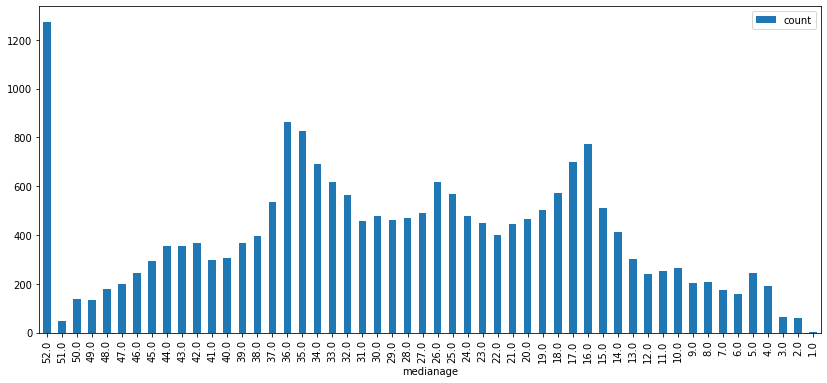

In [ ]:
result_df.toPandas().plot.bar(x='medianage',figsize=(14, 6))

Most of the residents are either in their youth or they settle here during their senior years. 

In [ ]:
df.describe()

DataFrame[summary: string, long: string, lat: string, medianage: string, rooms: string, bedrooms: string, population: string, households: string, medianincome: string, medianhousevalue: string]

In [ ]:
(df.describe().select(
                    "summary",
                    F.round("medianage", 4).alias("medianage"),
                    F.round("rooms", 4).alias("rooms"),
                    F.round("bedrooms", 4).alias("bedrooms"),
                    F.round("population", 4).alias("population"),
                    F.round("households", 4).alias("households"),
                    F.round("medianincome", 4).alias("medianincome"),
                    F.round("medianhousevalue", 4).alias("medianhousevalue"))
                    .show())

+-------+---------+---------+--------+----------+----------+------------+----------------+
|summary|medianage|    rooms|bedrooms|population|households|medianincome|medianhousevalue|
+-------+---------+---------+--------+----------+----------+------------+----------------+
|  count|  20640.0|  20640.0| 20640.0|   20640.0|   20640.0|     20640.0|         20640.0|
|   mean|  28.6395|2635.7631| 537.898| 1425.4767|  499.5397|      3.8707|     206855.8169|
| stddev|  12.5856|2181.6153|421.2479| 1132.4621|  382.3298|      1.8998|     115395.6159|
|    min|      1.0|      2.0|     1.0|       3.0|       1.0|      0.4999|         14999.0|
|    max|     52.0|  39320.0|  6445.0|   35682.0|    6082.0|     15.0001|        500001.0|
+-------+---------+---------+--------+----------+----------+------------+----------------+



Looking at the minimum and maximum values of all the (numerical) attributes. We see that multiple attributes have a wide range of values: we will need to normalize your dataset.

With all this information that we gathered from our small exploratory data analysis, we know enough to preprocess our data to feed it to the model.

- we shouldn't care about missing values; all zero values have been excluded from the data set.
- We should probably standardize our data, as we have seen that the range of minimum and maximum values is quite big.
- There are possibly some additional attributes that we could add, such as a feature that registers the number of bedrooms per room or the rooms per household.
- Our dependent variable is also quite big; To make our life easier, we'll have to adjust the values slightly.

# **Data Preprocessing**

First, let's start with the medianHouseValue, our dependent variable. To facilitate our working with the target values, we will express the house values in units of 100,000. That means that a target such as 452600.000000 should become 4.526

In [ ]:
df = df.withColumn("medianhousevalue", col("medianhousevalue")/100000)

In [ ]:
df.show(2)

+-------+-----+---------+------+--------+----------+----------+------------+----------------+
|   long|  lat|medianage| rooms|bedrooms|population|households|medianincome|medianhousevalue|
+-------+-----+---------+------+--------+----------+----------+------------+----------------+
|-122.23|37.88|     41.0| 880.0|   129.0|     322.0|     126.0|      8.3252|           4.526|
|-122.22|37.86|     21.0|7099.0|  1106.0|    2401.0|    1138.0|      8.3014|           3.585|
+-------+-----+---------+------+--------+----------+----------+------------+----------------+
only showing top 2 rows



# Feature Engineering 

Now that we have adjusted the values in medianHouseValue, we will now add the following columns to the data set:

- Rooms per household which refers to the number of rooms in households per block group;
- Population per household, which basically gives us an indication of how many people live in households per block group; And
- Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group



In [ ]:
from pyspark.sql.functions import *
df.select([count(when(isnull(c), c))\
.alias(c) for c in df.columns]).show()

+----+---+---------+-----+--------+----------+----------+------------+----------------+
|long|lat|medianage|rooms|bedrooms|population|households|medianincome|medianhousevalue|
+----+---+---------+-----+--------+----------+----------+------------+----------------+
|   0|  0|        0|    0|       0|         0|         0|           0|               0|
+----+---+---------+-----+--------+----------+----------+------------+----------------+



#1. Given the other variables present in the dataset, can we predict the price of an unseen home?

In [ ]:
df.columns

['long',
 'lat',
 'medianage',
 'rooms',
 'bedrooms',
 'population',
 'households',
 'medianincome',
 'medianhousevalue']

In [ ]:
df = (df.withColumn("roomsperhousehold", F.round(col("rooms")/col("households"), 2))
                  .withColumn("populationperhousehold", F.round(col("population")/col("households"), 2))
                  .withColumn("bedroomsperhousehold", F.round(col("bedrooms")/col("rooms"), 2)))

In [ ]:
df.show(5)

+-------+-----+---------+------+--------+----------+----------+------------+----------------+-----------------+----------------------+--------------------+
|   long|  lat|medianage| rooms|bedrooms|population|households|medianincome|medianhousevalue|roomsperhousehold|populationperhousehold|bedroomsperhousehold|
+-------+-----+---------+------+--------+----------+----------+------------+----------------+-----------------+----------------------+--------------------+
|-122.23|37.88|     41.0| 880.0|   129.0|     322.0|     126.0|      8.3252|           4.526|             6.98|                  2.56|                0.15|
|-122.22|37.86|     21.0|7099.0|  1106.0|    2401.0|    1138.0|      8.3014|           3.585|             6.24|                  2.11|                0.16|
|-122.24|37.85|     52.0|1467.0|   190.0|     496.0|     177.0|      7.2574|           3.521|             8.29|                   2.8|                0.13|
|-122.25|37.85|     52.0|1274.0|   235.0|     558.0|     219.0| 

In [ ]:
df_new = df.select("medianhousevalue", 
                "bedrooms", 
                "population", 
                "households", 
                "medianincome", 
                "roomsperhousehold", 
                "populationperhousehold", 
                "bedroomsperhousehold")

In [ ]:
featureCols = ["bedrooms", "population", "households", "medianincome", "roomsperhousehold", "populationperhousehold", "bedroomsperhousehold"]

In [ ]:
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 
assembled_df = assembler.transform(df_new)
assembled_df.show(10, truncate=False)

+----------------+--------+----------+----------+------------+-----------------+----------------------+--------------------+-------------------------------------------------------+
|medianhousevalue|bedrooms|population|households|medianincome|roomsperhousehold|populationperhousehold|bedroomsperhousehold|features                                               |
+----------------+--------+----------+----------+------------+-----------------+----------------------+--------------------+-------------------------------------------------------+
|4.526           |129.0   |322.0     |126.0     |8.3252      |6.98             |2.56                  |0.15                |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585           |1106.0  |2401.0    |1138.0    |8.3014      |6.24             |2.11                  |0.16                |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521           |190.0   |496.0     |177.0     |7.2574      |8.29             |2.8            

In [ ]:
# Initialize the standardScaler
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [ ]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

In [ ]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=1)

In [ ]:
from pyspark.ml.regression import LinearRegression
linearReg= LinearRegression(featuresCol= 'features_scaled', labelCol= "medianhousevalue")
#fit the model to the the training data
model=linearReg.fit(train_data)
#make predictions on the test set
predictions= model.transform(test_data)
# show the predicted values and the actual values
predictions.select("prediction" ,"medianhousevalue").show(10)

+--------------------+----------------+
|          prediction|medianhousevalue|
+--------------------+----------------+
|  1.9676036684951883|           0.175|
|-0.34574768222089025|           0.283|
|    1.31751111153962|             0.3|
|  0.9997795241697434|             0.3|
|   1.395890718527408|           0.325|
|  1.3044909053611071|           0.375|
|   1.300952173986197|           0.379|
|  1.7729607356212862|           0.388|
|  2.2007431681601197|             0.4|
|  1.9230875886369854|           0.404|
+--------------------+----------------+
only showing top 10 rows



In [ ]:
#R2 score on test set
r2_test= model.evaluate(test_data).r2
print("R2 score on test set: ", r2_test)
from pyspark.ml.evaluation import RegressionEvaluator
#RMSE on test set
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medianhousevalue",metricName="rmse")
rmse_test = evaluator.evaluate(predictions)
print("RMSE on test set: ", rmse_test)

R2 score on test set:  0.5532429998171401
RMSE on test set:  0.7803180382571191


#2. Can we generate a relatively reliable prediction of home value given only longitude, latitude, total rooms, and total bedrooms?

In [ ]:
df_new2 = df.select("medianhousevalue",
                "long", 
                "lat", 
                "rooms", 
                "bedrooms")

In [ ]:
df_new2.show(5)

+----------------+-------+-----+------+--------+
|medianhousevalue|   long|  lat| rooms|bedrooms|
+----------------+-------+-----+------+--------+
|           4.526|-122.23|37.88| 880.0|   129.0|
|           3.585|-122.22|37.86|7099.0|  1106.0|
|           3.521|-122.24|37.85|1467.0|   190.0|
|           3.413|-122.25|37.85|1274.0|   235.0|
|           3.422|-122.25|37.85|1627.0|   280.0|
+----------------+-------+-----+------+--------+
only showing top 5 rows



In [ ]:
featureCols2 = ["long", "lat", "rooms", "bedrooms"]

In [ ]:
assembler2 = VectorAssembler(inputCols=featureCols2, outputCol="features2") 
assembled_df2 = assembler2.transform(df_new2)
assembled_df2.show(10, truncate=False)

+----------------+-------+-----+------+--------+-----------------------------------------------------+
|medianhousevalue|long   |lat  |rooms |bedrooms|features2                                            |
+----------------+-------+-----+------+--------+-----------------------------------------------------+
|4.526           |-122.23|37.88|880.0 |129.0   |[-122.2300033569336,37.880001068115234,880.0,129.0]  |
|3.585           |-122.22|37.86|7099.0|1106.0  |[-122.22000122070312,37.86000061035156,7099.0,1106.0]|
|3.521           |-122.24|37.85|1467.0|190.0   |[-122.23999786376953,37.849998474121094,1467.0,190.0]|
|3.413           |-122.25|37.85|1274.0|235.0   |[-122.25,37.849998474121094,1274.0,235.0]            |
|3.422           |-122.25|37.85|1627.0|280.0   |[-122.25,37.849998474121094,1627.0,280.0]            |
|2.697           |-122.25|37.85|919.0 |213.0   |[-122.25,37.849998474121094,919.0,213.0]             |
|2.992           |-122.25|37.84|2535.0|489.0   |[-122.25,37.8400001525878

In [ ]:
# Initialize the standardScaler
standardScaler2 = StandardScaler(inputCol="features2", outputCol="features_scaled2")
# Fit the DataFrame to the scaler
scaled_df2 = standardScaler2.fit(assembled_df2).transform(assembled_df2)
scaled_df2.select("features2", "features_scaled2").show(10, truncate=False)

+-----------------------------------------------------+------------------------------------------------------------------------------+
|features2                                            |features_scaled2                                                              |
+-----------------------------------------------------+------------------------------------------------------------------------------+
|[-122.2300033569336,37.880001068115234,880.0,129.0]  |[-61.00727067992717,17.73447826464273,0.40337085073160667,0.30623297630686513]|
|[-122.22000122070312,37.86000061035156,7099.0,1106.0]|[-61.00227842748807,17.725114545701565,3.2540109878905406,2.6255323394991694] |
|[-122.23999786376953,37.849998474121094,1467.0,190.0]|[-61.012259124393395,17.720431793257596,0.6724375432082579,0.451040817816313] |
|[-122.25,37.849998474121094,1274.0,235.0]            |[-61.01725137683249,17.720431793257596,0.5839709816273487,0.557866274667545]  |
|[-122.25,37.849998474121094,1627.0,280.0]            |

In [ ]:
#splitting the data 
train_data, test_data = scaled_df2.randomSplit([0.8,0.2], seed=1)

In [ ]:
from pyspark.ml.regression import LinearRegression
linearReg= LinearRegression(featuresCol= 'features_scaled2', labelCol= "medianhousevalue")
#fit the model to the the training data
model=linearReg.fit(train_data)
#make predictions on the test set
predictions= model.transform(test_data)
# show the predicted values and the actual values
predictions.select("prediction" ,"medianhousevalue").show(10)

+--------------------+----------------+
|          prediction|medianhousevalue|
+--------------------+----------------+
|  2.0296178823249207|           0.175|
|    4.86815894868959|           0.283|
|  2.3511420799879517|             0.3|
|  0.6417864685929118|             0.3|
|  1.1723173535796505|           0.325|
|  2.8190519710028212|           0.375|
|  2.2763425168108853|           0.379|
|  2.0100909738508435|           0.388|
|-0.48479287289755035|             0.4|
|  0.6071881322387753|           0.404|
+--------------------+----------------+
only showing top 10 rows



In [ ]:
#R2 score on test set
r2_test= model.evaluate(test_data).r2
print("R2 score on test set: ", r2_test)
from pyspark.ml.evaluation import RegressionEvaluator
#RMSE on test set
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medianhousevalue",metricName="rmse")
rmse_test = evaluator.evaluate(predictions)
print("RMSE on test set: ", rmse_test)

R2 score on test set:  0.29651318354285827
RMSE on test set:  0.9791831803061672


#3. Can we use median age to help predict housing prices on its own?

In [ ]:
df.show(5)

+-------+-----+---------+------+--------+----------+----------+------------+----------------+-----------------+----------------------+--------------------+
|   long|  lat|medianage| rooms|bedrooms|population|households|medianincome|medianhousevalue|roomsperhousehold|populationperhousehold|bedroomsperhousehold|
+-------+-----+---------+------+--------+----------+----------+------------+----------------+-----------------+----------------------+--------------------+
|-122.23|37.88|     41.0| 880.0|   129.0|     322.0|     126.0|      8.3252|           4.526|             6.98|                  2.56|                0.15|
|-122.22|37.86|     21.0|7099.0|  1106.0|    2401.0|    1138.0|      8.3014|           3.585|             6.24|                  2.11|                0.16|
|-122.24|37.85|     52.0|1467.0|   190.0|     496.0|     177.0|      7.2574|           3.521|             8.29|                   2.8|                0.13|
|-122.25|37.85|     52.0|1274.0|   235.0|     558.0|     219.0| 

In [ ]:
# defining medianage as our label/predictor variable
df3 = df.select(df.medianage, df.medianhousevalue.alias('label'))
# split data into 70% training and 30% testing data
training, test = df3.randomSplit([0.7, 0.3], seed = 100)
# assembler to assemble the features into vector form
assembler = VectorAssembler().setInputCols(['medianage',]).setOutputCol('features')
trainingSet = assembler.transform(training)
# select only features column and label column since we have already vectorised our features
trainingSet = trainingSet.select("features","label")

In [ ]:
from pyspark.ml.regression import LinearRegression
# fit the training set to linear regression model
lr = LinearRegression()
lr_Model = lr.fit(trainingSet)
# assembler to assemble the features into vector form
testSet = assembler.transform(test)
# select only features column and label column since we have already vectorised our features
testSet = testSet.select("features", "label")
# fit the testing data into our linear regression model
testSet = lr_Model.transform(testSet)
testSet.show(truncate=False)

+--------+-------+------------------+
|features|label  |prediction        |
+--------+-------+------------------+
|[1.0]   |1.913  |1.8097990352332143|
|[2.0]   |1.142  |1.8193061102284969|
|[2.0]   |1.221  |1.8193061102284969|
|[2.0]   |1.367  |1.8193061102284969|
|[2.0]   |1.374  |1.8193061102284969|
|[2.0]   |1.459  |1.8193061102284969|
|[2.0]   |1.463  |1.8193061102284969|
|[2.0]   |1.648  |1.8193061102284969|
|[2.0]   |1.81   |1.8193061102284969|
|[2.0]   |1.967  |1.8193061102284969|
|[2.0]   |2.044  |1.8193061102284969|
|[2.0]   |2.101  |1.8193061102284969|
|[2.0]   |2.145  |1.8193061102284969|
|[2.0]   |2.208  |1.8193061102284969|
|[2.0]   |2.225  |1.8193061102284969|
|[2.0]   |2.985  |1.8193061102284969|
|[2.0]   |3.295  |1.8193061102284969|
|[2.0]   |4.841  |1.8193061102284969|
|[2.0]   |5.00001|1.8193061102284969|
|[3.0]   |0.832  |1.8288131852237797|
+--------+-------+------------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator()
print(evaluator.evaluate(testSet, {evaluator.metricName: "r2"}))

0.012153001720492496


The r2 shows its a bad predictor